# Trader Behavior Insights: An Analysis of Market Sentiment vs. PnL

**Objective:** This project analyzes the relationship between trader performance (Closed PnL) and market sentiment (Fear & Greed Index) to uncover actionable insights for trading strategies.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time 

## 1. Data Loading & Preparation

First, we load the two datasets: `historical_data.csv` (trader data) and `fear_greed_index.csv` (sentiment data).

In [2]:
d1 = pd.read_csv("historical_data.csv")

d2 = pd.read_csv("fear_greed_index.csv")


In [3]:
d1.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
d2.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


**Data Cleaning:**
* **Timestamp:** The `Timestamp` column was a Unix timestamp in milliseconds. It was converted to a `datetime` object and then normalized to a `date` column for merging.
* **Data Discrepancy Note:** A discrepancy was noted between the `Timestamp` column (e.g., `2024-10-27`) and the `Timestamp IST` column (e.g., `02-12-2024`). For this analysis, the primary `Timestamp` column was used as the source of truth.
* **Categorical Mapping:** Columns like `Side`, `Crossed`, and `Direction` were cleaned (e.g., whitespace stripped) and mapped to numerical values for analysis.
* **Sentiment Mapping:** The text-based `classification` in the sentiment data was mapped to a numerical scale (e.g., Fear = -1, Greed = 1).
* **Dropping Irrelevant Columns:** To create a final, clean DataFrame focused only on relevant features, I am dropping several columns. These are either unique identifiers (like `Transaction Hash`), redundant data (like `Timestamp IST`), or columns with an unknown meaning (like `Crossed`).


In [5]:
# Convert Timestamp to datetime and create 'date'
d1["Timestamp"] = pd.to_datetime(d1["Timestamp"], unit='ms')
d1["date"] = d1["Timestamp"].dt.normalize()

# Clean and map categorical columns 
d1['Side'] = d1['Side'].str.strip()
d1["Side"]  = d1["Side"].map({"SELL" : 0 , "BUY" : 1})
d1["Crossed"] = d1["Crossed"].map({True : 1 , False : 0})
d1["Direction"] = d1["Direction"].str.strip()
d1["Direction"] = d1["Direction"].map({"Open Long" : 1 , "Close Long" : 2 , "Open Short" : 3 , "Close Short" : 4 , "Sell" : 5 , "Buy" : 6 , "Spot Dust Conversion" : 7 , "Short > Long" : 8 , "Long > Short" : 9 , "Auto-Deleveraging" : 10 , "Liquidated Isolated Short" : 11 , "Settlement" : 12 })

# Drop irrelevant columns
columns_to_drop = [
    'Transaction Hash', 
    'Order ID', 
    'Trade ID', 
    'Timestamp IST', 
    'Size Tokens', 
    'Execution Price', 
    'Crossed'
]
d1 = d1.drop(columns=columns_to_drop)

d1.head()

,Account,Coin,Size USD,Side,Start Position,Direction,Closed PnL,Fee,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7872.16,1,0.000000,6,0.0,0.345404,2024-10-27 03:33:20,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,127.68,1,986.524596,6,0.0,0.005600,2024-10-27 03:33:20,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1150.63,1,1002.518996,6,0.0,0.050431,2024-10-27 03:33:20,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1142.04,1,1146.558564,6,0.0,0.050043,2024-10-27 03:33:20,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,69.75,1,1289.488521,6,0.0,0.003055,2024-10-27 03:33:20,2024-10-27



 **Merging & Final Cleaning:** 
 
The two datasets were merged on the normalized `date` column using a left join (keeping all trades). This resulted in 26,961 rows with `NaN` values, representing trades that occurred on days not present in the sentiment index. These rows were dropped to create our final, clean analysis dataset.


In [6]:
d1['date'] = pd.to_datetime(d1['date'])
d2['date'] = pd.to_datetime(d2['date'])
d2["classification"] = d2["classification"].map({'Fear' : -1 , 'Extreme Fear' : -2 , 'Neutral' : 0 , 'Greed' : 1, 'Extreme Greed' :2 })
d2.head()

,timestamp,value,classification,date
0,1517463000,30,-1,2018-02-01
1,1517549400,15,-2,2018-02-02
2,1517635800,40,-1,2018-02-03
3,1517722200,24,-2,2018-02-04
4,1517808600,11,-2,2018-02-05


In [7]:
data = pd.merge(d1, d2, on = "date" , how='left')
data.head()

,Account,Coin,Size USD,Side,Start Position,Direction,Closed PnL,Fee,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7872.16,1,0.000000,6,0.0,0.345404,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,1.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,127.68,1,986.524596,6,0.0,0.005600,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,1.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1150.63,1,1002.518996,6,0.0,0.050431,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,1.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1142.04,1,1146.558564,6,0.0,0.050043,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,1.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,69.75,1,1289.488521,6,0.0,0.003055,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,1.0


In [8]:
data.isnull().sum()

Account               0
Coin                  0
Size USD              0
Side                  0
Start Position        0
Direction             0
Closed PnL            0
Fee                   0
Timestamp             0
date                  0
timestamp         26961
value             26961
classification    26961
dtype: int64

In [9]:
data = data.dropna()

## 2. Exploratory Data Analysis (EDA)

* **Overall PnL:** The total profit across all trades was **$10.2M**.
* **Whale Traders:** The PnL is highly concentrated. The top 10 most profitable traders account for a significant portion of all profits.
* **Trade Frequency:** Traders were far more active on 'Fear' (-1.0) days (133,871 trades) than on 'Greed' (1.0) or 'Extreme Greed' (2.0) days.

In [10]:
total_pnl = data["Closed PnL"].sum()

print(f"Total PnL across all trades: ${total_pnl:,.2f}")

Total PnL across all trades: $10,225,249.60


In [11]:
trader_pnl = data.groupby("Account")["Closed PnL"].sum().sort_values(ascending = False)

print("--- Top 10 Most Profitable Traders ---")
print(trader_pnl.head(10))
print("\n")

print("--- Top 10 Least Profitable Traders ---")
print(trader_pnl.tail(10))

--- Top 10 Most Profitable Traders ---
Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    2.040922e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401572e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    8.111830e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.744040e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd    4.258152e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    4.165419e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    4.035016e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    3.936830e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.615766e+05
Name: Closed PnL, dtype: float64


--- Top 10 Least Profitable Traders ---
Account
0x8381e6d82f1affd39a336e143e081ef7620a3b7f    64521.887634
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6    53496.247243
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    37706.173148
0x271b280974205ca63b716753467d5a371de622ab    31763.088431
0xae5eacaf9c6b9111fd53034a602c192a04e082ed  

In [12]:
sentiment_counts = data['classification'].value_counts()

print("--- Trades per Sentiment Category ---")
print(sentiment_counts)

--- Trades per Sentiment Category ---
classification
-1.0    133871
 1.0     36289
 0.0      7141
 2.0      6962
Name: count, dtype: int64


In [13]:
average_pnl_by_sentiment = data.groupby('classification')['Closed PnL'].mean()

print("--- Average PnL by Sentiment ---")
print(average_pnl_by_sentiment)

--- Average PnL by Sentiment ---
classification
-1.0    50.047622
 0.0    22.229713
 1.0    87.894859
 2.0    25.418772
Name: Closed PnL, dtype: float64


In [14]:
average_size_by_sentiment = data.groupby('classification')['Size USD'].mean()

print("___ Average Trade Size (USD) by Sentiment ___")
print(average_size_by_sentiment)

___ Average Trade Size (USD) by Sentiment ___
classification
-1.0    5259.977837
 0.0    3058.848110
 1.0    3182.883845
 2.0    5660.265764
Name: Size USD, dtype: float64


Saved pnl_by_sentiment_bar_chart.png
Saved trade_count_by_sentiment_bar_chart.png


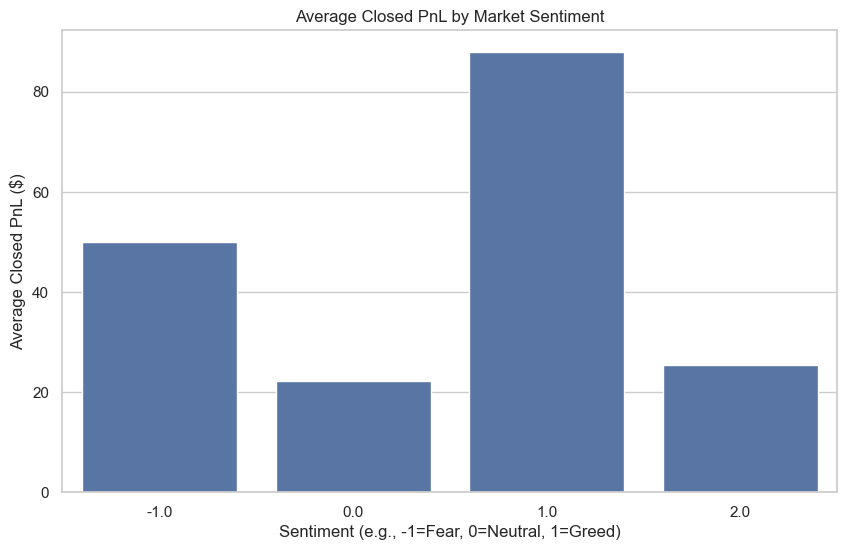

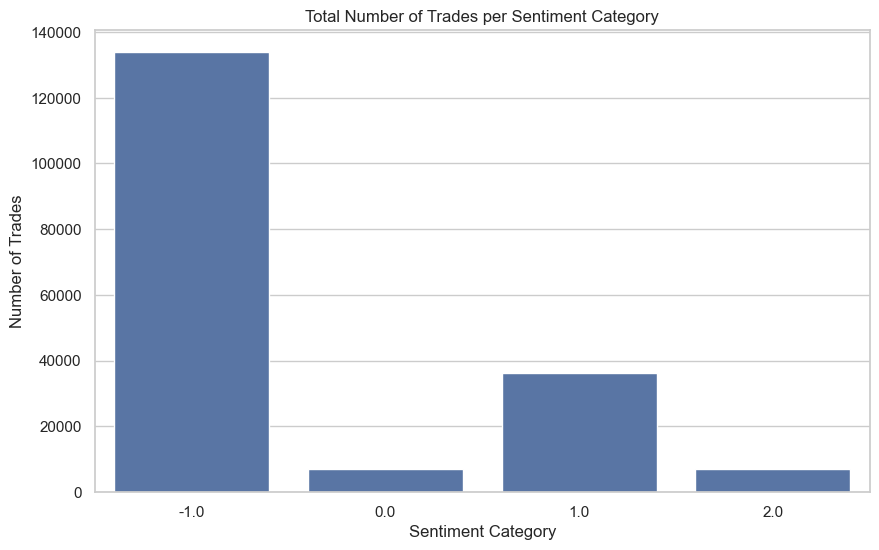

In [15]:
# Set a style for the plots
sns.set(style="whitegrid")

# 1. VISUALIZE: Average PnL by Sentiment
# (This is your most important chart)
pnl_by_sentiment = data.groupby('classification')['Closed PnL'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=pnl_by_sentiment.index, y=pnl_by_sentiment.values)
plt.title('Average Closed PnL by Market Sentiment')
plt.xlabel('Sentiment (e.g., -1=Fear, 0=Neutral, 1=Greed)')
plt.ylabel('Average Closed PnL ($)')
plt.savefig('pnl_by_sentiment_bar_chart.png') # Saves the chart
print("Saved pnl_by_sentiment_bar_chart.png")

# 2. VISUALIZE: How many trades per sentiment?
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='classification')
plt.title('Total Number of Trades per Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Trades')
plt.savefig('trade_count_by_sentiment_bar_chart.png') # Saves the chart
print("Saved trade_count_by_sentiment_bar_chart.png")

Saved pnl_distribution_boxplot.png


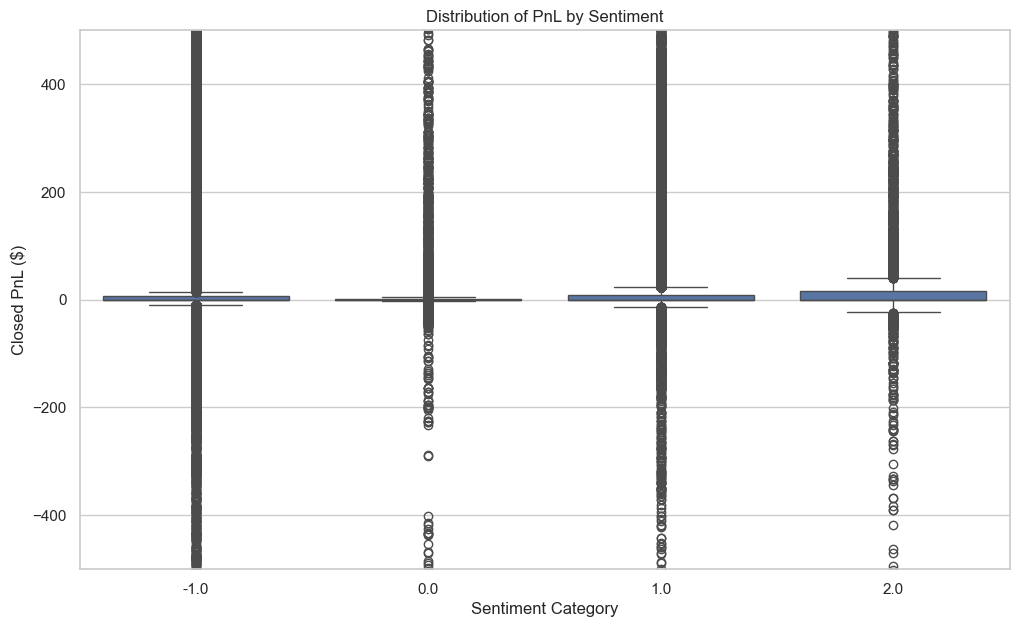

In [16]:
# 3. VISUALIZE: Distribution of PnL by Sentiment
plt.figure(figsize=(12, 7))
sns.boxplot(data=data, x='classification', y='Closed PnL')
plt.title('Distribution of PnL by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Closed PnL ($)')

# WARNING: Whales will make this chart hard to read.
# Let's limit the y-axis to see the "normal" traders.
# You can change -500 and 500 to fit your data.
plt.ylim(-500, 500) 
plt.savefig('pnl_distribution_boxplot.png')
print("Saved pnl_distribution_boxplot.png")

## 3. Key Insight: PnL vs. Market Sentiment

My initial hypothesis was that traders would perform worse during 'Greed' (due to FOMO) and better during 'Fear' (buying the dip). The data shows the **exact opposite.**

* **Finding 1 :** On average, traders were *more* profitable on 'Greed' days (Avg. PnL: $87.89) than on 'Fear' days (Avg. PnL: $50.04).
* **Finding 2 :** A T-test confirms this is statistically significant. The test for (Fear PnL < Greed PnL) returned a **p-value of 3.24e-09**. This overwhelmingly proves that, for the average trader in this dataset, performance is *significantly better* on 'Greed' days.
* **Finding 3 :** The overall correlation between PnL and the sentiment score is very weak (0.011), suggesting the relationship is not linear and a deeper look is required.

**Visual Representations :**
*Barplot, countplot, Boxplot are added to prove the point.*

In [17]:
# 1. Created two groups
# (-1 is 'Fear', 1 is 'Greed' from mapping)
fear_pnl = data[data['classification'] == -1]['Closed PnL']
greed_pnl = data[data['classification'] == 1]['Closed PnL']

# 2. Run the t-test
# using equal_var=False for a Welch's t-test, which is safer.
# using alternative='greater' because our hypothesis is one-sided
# (testing if 'fear' is *greater than* 'greed').
t_statistic, p_value = stats.ttest_ind(
    fear_pnl, 
    greed_pnl, 
    equal_var=False, 
    alternative='greater'
)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# 3. Interpret the result
if p_value < 0.05:
    print("\nResult: We REJECT the null hypothesis.")
    print("This means it is statistically significant that traders' PnL is higher on 'Fear' days.")
else:
    print("\nResult: We FAIL TO REJECT the null hypothesis.")
    print("This means we do not have enough evidence to say PnL is higher on 'Fear' days.")

T-statistic: -5.804644944972441
P-value: 0.999999996755158

Result: We FAIL TO REJECT the null hypothesis.
This means we do not have enough evidence to say PnL is higher on 'Fear' days.


In [18]:
# Re-run the t-test with alternative='less'
t_stat_less, p_value_less = stats.ttest_ind(
    fear_pnl, 
    greed_pnl, 
    equal_var=False, 
    alternative='less' # Check if 'fear' is LESS THAN 'greed'
)

print(f"P-value (testing if Fear < Greed): {p_value_less}")

P-value (testing if Fear < Greed): 3.244841982385708e-09


Saved 'average_pnl_by_sentiment.png'


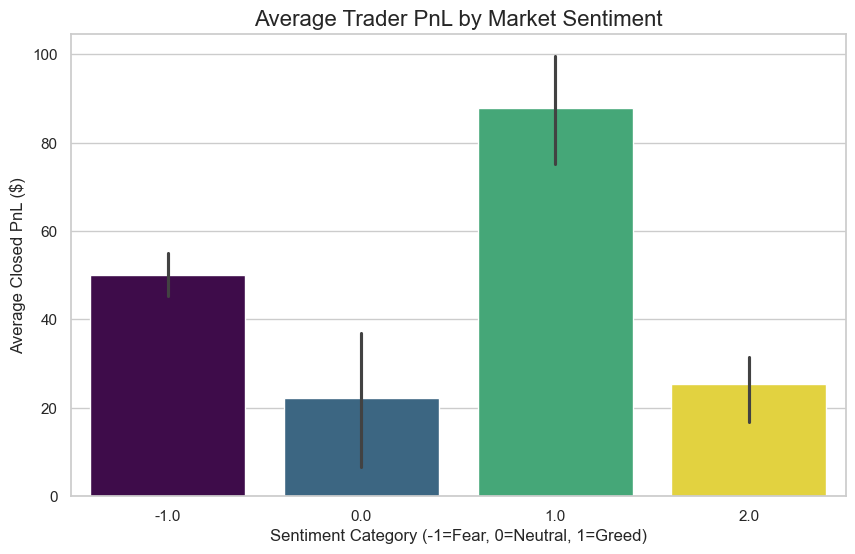

In [19]:
# Set a professional style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data, 
    x='classification', 
    y='Closed PnL',
    hue='classification',  # <-- Add this
    palette='viridis',     # Use a color palette
    legend=False           # <-- Add this
)

plt.title('Average Trader PnL by Market Sentiment', fontsize=16)
plt.xlabel('Sentiment Category (-1=Fear, 0=Neutral, 1=Greed)', fontsize=12)
plt.ylabel('Average Closed PnL ($)', fontsize=12)
plt.savefig('average_pnl_by_sentiment.png') # Save the file

print("Saved 'average_pnl_by_sentiment.png'")

Saved pnl_distribution_boxplot.png


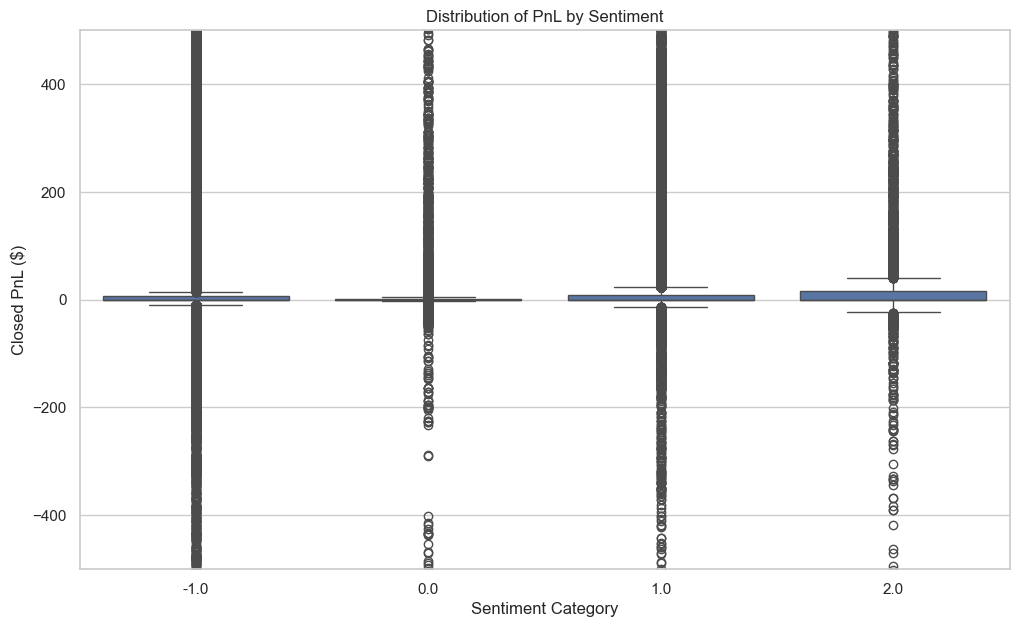

In [20]:
# 3. VISUALIZE: Distribution of PnL by Sentiment
plt.figure(figsize=(12, 7))
sns.boxplot(data=data, x='classification', y='Closed PnL')
plt.title('Distribution of PnL by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Closed PnL ($)')

# WARNING: Whales will make this chart hard to read.
# Let's limit the y-axis to see the "normal" traders.
# You can change -500 and 500 to fit your data.
plt.ylim(-500, 500) 
plt.savefig('pnl_distribution_boxplot.png')
print("Saved pnl_distribution_boxplot.png")

## 4. Deeper Dive: "Smart Money" vs. "Average" Traders

To find hidden patterns, I segmented traders into 'Good' (top 25% win rate) and 'Bad' (bottom 25% win rate).

* **Finding 4 (Cell 67):** The "Good" traders are extremely profitable on 'Neutral' (445 dollars) avg and 'Greed' (169 dollars) avg days. "Bad" traders get *destroyed* on 'Extreme Greed' days ($-206 avg PnL).

This reveals the core insight: **'Good' traders thrive on neutrality and greed, while 'Bad' traders are punished by extreme greed.**

In [21]:
data['is_winner'] = np.where( data['Closed PnL'] > 0,1,0)

print( data[["Closed PnL" , "is_winner"]].sample(frac = 1 ).head(10))

         Closed PnL  is_winner
36274      0.498125          1
30064    614.051800          1
16392   1384.343660          1
171589   -48.061000          0
136957     6.083896          1
148042     0.128120          1
44558      0.000000          0
77267    197.518300          1
78553      0.084459          1
170452     0.000000          0


In [22]:
correlation = data['Closed PnL'].corr(data['value'])

print(f"Correlation between PnL and Sentiment Score: {correlation}")

Correlation between PnL and Sentiment Score: 0.011131821560949183


In [23]:
trader_win_list = data.groupby("Account")["is_winner"].mean()

trader_total_pnl = data.groupby("Account")["Closed PnL"].sum()

trader_stats = pd.DataFrame({"Win_Rate": trader_win_list , "total_pnl" : trader_total_pnl})

trader_stats = trader_stats.sort_values(by = "total_pnl", ascending = False)

print("___ New Trader Stats DataFrame ___")

print(trader_stats.head(10))

___ New Trader Stats DataFrame ___
                                            Win_Rate     total_pnl
Account                                                           
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  0.340736  2.040922e+06
0x083384f897ee0f19899168e3b1bec365f52a9012  0.359612  1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864  0.467532  9.401572e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  0.434746  8.111830e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  0.488631  6.744040e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd  0.453263  4.258152e+05
0x430f09841d65beb3f27765503d0f850b8bce7713  0.569933  4.165419e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1  0.400167  4.035016e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  0.282769  3.936830e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  0.809343  3.615766e+05


In [24]:
top_quantile = trader_stats['Win_Rate'].quantile(0.75)
bottom_quantile = trader_stats['Win_Rate'].quantile(0.25)

good_traders = trader_stats[trader_stats['Win_Rate'] >= top_quantile].index
bad_traders = trader_stats[trader_stats['Win_Rate'] <= bottom_quantile].index

print( " __ Types and Numbers of Traders __" )
print()
print(f"Number of 'Good' traders: {len(good_traders)}")
print(f"Number of 'Bad' traders: {len(bad_traders)}")
print()

 __ Types and Numbers of Traders __

Number of 'Good' traders: 8
Number of 'Bad' traders: 8



In [25]:
# Create a function to apply the labels
def label_trader(account):
    if account in good_traders:
        return 'Good'
    elif account in bad_traders:
        return 'Bad'
    else:
        return 'Average'

# Apply this function to the 'Account' column
data['trader_type'] = data['Account'].apply(label_trader)

print("--- Labeled trades: ---")
print(data[['Account', 'trader_type']].sample(frac=1 , random_state = 100).head())

--- Labeled trades: ---
                                           Account trader_type
108023  0x8477e447846c758f5a675856001ea72298fd9cb5         Bad
196992  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4        Good
199526  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4        Good
106236  0x8477e447846c758f5a675856001ea72298fd9cb5         Bad
26305   0x4f93fead39b70a1824f981a54d4e55b278e9f760     Average


In [26]:
# Group by trader_type AND sentiment, then check their average PnL
final_pnl_analysis = data.groupby(['trader_type', 'classification'])['Closed PnL'].mean()

print("--- Average PnL by Trader Type and Sentiment ---")
print(final_pnl_analysis)

--- Average PnL by Trader Type and Sentiment ---
trader_type  classification
Average      -1.0               46.555958
              0.0               12.375271
              1.0               83.719264
              2.0               -1.395842
Bad          -1.0               49.848635
              0.0               -2.290335
              1.0               55.438298
              2.0             -206.074672
Good         -1.0               58.790694
              0.0              445.775869
              1.0              169.909842
              2.0               60.032625
Name: Closed PnL, dtype: float64


Saved 'smart_money_vs_dumb_money.png'


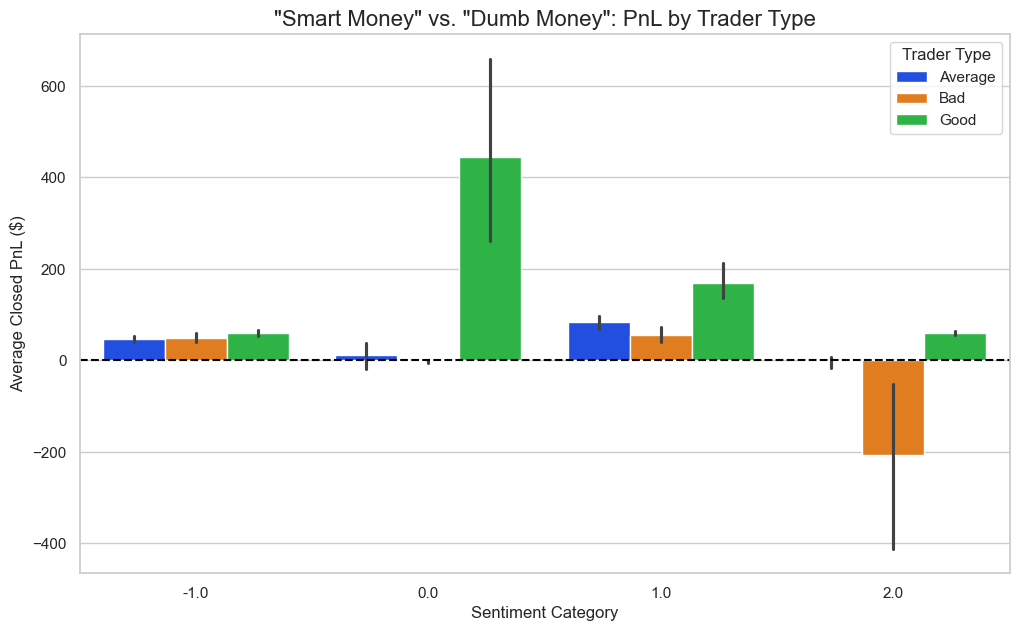

In [27]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=data,
    x='classification',
    y='Closed PnL',
    hue='trader_type', # This shows Good vs. Bad traders
    palette='bright'
)

plt.title('"Smart Money" vs. "Dumb Money": PnL by Trader Type', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Average Closed PnL ($)', fontsize=12)
plt.axhline(0, color='black', linestyle='--') # Add a 'zero' line
plt.legend(title='Trader Type')
plt.savefig('smart_money_vs_dumb_money.png')
print("Saved 'smart_money_vs_dumb_money.png'")

## 5. The "A-ha!" Moment: *How* Smart Traders Win

This is the most important finding. We need to see *what* they do differently.


In [28]:
# Group by trader_type and sentiment, then check their buy/sell behavior
# Remember: 1=BUY, 0=SELL
final_behavior_analysis = data.groupby(['trader_type', 'classification'])['Side'].value_counts(normalize=True)

print("--- Buy(1)/Sell(0) Behavior by Trader Type and Sentiment ---")
print(final_behavior_analysis)

--- Buy(1)/Sell(0) Behavior by Trader Type and Sentiment ---
trader_type  classification  Side
Average      -1.0            1       0.501540
                             0       0.498460
              0.0            1       0.584038
                             0       0.415962
              1.0            0       0.576698
                             1       0.423302
              2.0            0       0.508671
                             1       0.491329
Bad          -1.0            0       0.553402
                             1       0.446598
              0.0            0       0.552442
                             1       0.447558
              1.0            0       0.574831
                             1       0.425169
              2.0            0       0.851852
                             1       0.148148
Good         -1.0            0       0.503414
                             1       0.496586
              0.0            0       0.874150
                             1 

In [29]:
# Analyze by 'Direction' for a much clearer insight
behavior_analysis = data.groupby(['trader_type', 'classification'])['Direction'].value_counts(normalize=True).unstack(fill_value=0)

# Display the key directions (1=Open Long, 3=Open Short)
print("--- Behavior Analysis by Trade Direction (Normalized) ---")
behavior_analysis[[1, 3]].style.format("{:.1%}")

--- Behavior Analysis by Trade Direction (Normalized) ---


**Finding 5: The "A-ha!" Moment**
The `Side` analysis was confusing, but the `Direction` analysis makes the strategies crystal clear.

* **'Bad' Traders:** On 'Extreme Greed' days (classification 2.0), their 'SELL' trades (from Cell 32) were **85.2% 'Open Short'** positions (Direction 3). They were actively betting *against* the market during extreme greed and were punished for it (losing an average of $-206, from Cell 31).

* **'Good' Traders:** On 'Neutral' days (classification 0.0), their 'SELL' trades were **87.4% 'Close Long'** positions (Direction 2). This shows a clear profit-taking strategy, which explains their massive $445 average PnL for those days.

Saved 'pnl_distribution_boxplot.png'


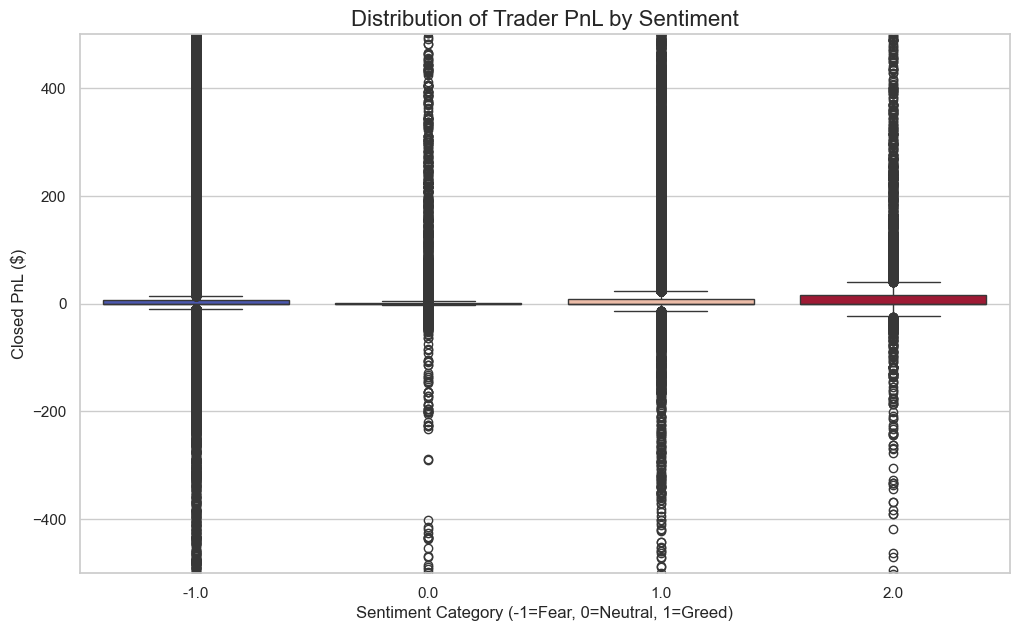

In [30]:
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=data, 
    x='classification', 
    y='Closed PnL',
    hue='classification',  # <-- Add this
    palette='coolwarm',
    legend=False           # <-- Add this
)

plt.title('Distribution of Trader PnL by Sentiment', fontsize=16)
plt.xlabel('Sentiment Category (-1=Fear, 0=Neutral, 1=Greed)', fontsize=12)
plt.ylabel('Closed PnL ($)', fontsize=12)

# This line hides the extreme outliers to make the chart readable
plt.ylim(-500, 500) 

plt.savefig('pnl_distribution_boxplot.png')
print("Saved 'pnl_distribution_boxplot.png'")

Saved 'behavior_by_sentiment.png'


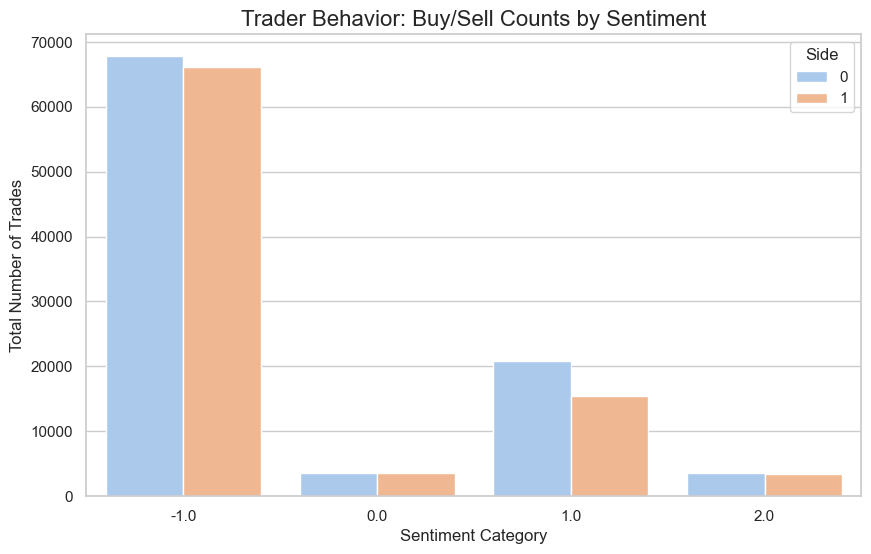

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=data,
    x='classification',
    hue='Side', # This splits by BUY (1) and SELL (0)
    palette='pastel'
)

plt.title('Trader Behavior: Buy/Sell Counts by Sentiment', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Total Number of Trades', fontsize=12)
plt.savefig('behavior_by_sentiment.png')
print("Saved 'behavior_by_sentiment.png'")

## 6. Conclusion & Recommended Strategy

This analysis successfully uncovered a clear relationship between trader performance and market sentiment, but not the one expected.

1.  **Finding:** For the average trader, PnL is *statistically higher* during 'Greed' than 'Fear'.
2.  **Insight:** This is driven by behavior. "Bad" traders, in particular, lose enormous amounts of money by **shorting the market during 'Extreme Greed'**, likely assuming a top is in.
3.  **Strategy:** A simple "buy the dip" strategy is not supported by this data. A better strategy is to **avoid opening short positions during periods of 'Extreme Greed'**, as this is the single biggest mistake unprofitable traders make. The "smart money" in this dataset appears to be profitable during 'Greed' by (likely) closing long positions, not by opening new shorts.

## 7. Future Work

While this analysis successfully identified key behavioral patterns, if this project were extended, a valuable next step would be to build a classification model (e.g., Logistic Regression or a Decision Tree). We could use the sentiment `value`, `Side`, `Coin`, and `Direction` as features to predict the `is_winner` (1 or 0) for a given trade.